[H-ESP] Generation 0: avg reward = -479.40, best = -127.77
[H-ESP] Generation 1: avg reward = -544.32, best = -121.88
[H-ESP] Generation 2: avg reward = -399.66, best = -108.31
[H-ESP] Generation 3: avg reward = -492.86, best = -118.67
[H-ESP] Generation 4: avg reward = -385.65, best = 40.19
[H-ESP] Generation 5: avg reward = -373.31, best = -82.29
[H-ESP] Generation 6: avg reward = -385.45, best = -65.62
[H-ESP] Generation 7: avg reward = -434.10, best = -108.73
[H-ESP] Generation 8: avg reward = -478.92, best = -113.85
[H-ESP] Generation 9: avg reward = -472.50, best = -87.22
[H-ESP] Generation 10: avg reward = -455.92, best = -116.79
[H-ESP] Generation 11: avg reward = -520.73, best = -100.70
[H-ESP] Generation 12: avg reward = -433.48, best = -123.20
[H-ESP] Generation 13: avg reward = -437.87, best = -106.06
[H-ESP] Generation 14: avg reward = -461.48, best = -86.60
[H-ESP] Generation 15: avg reward = -450.27, best = -106.01
[H-ESP] Generation 16: avg reward = -389.91, best = -108

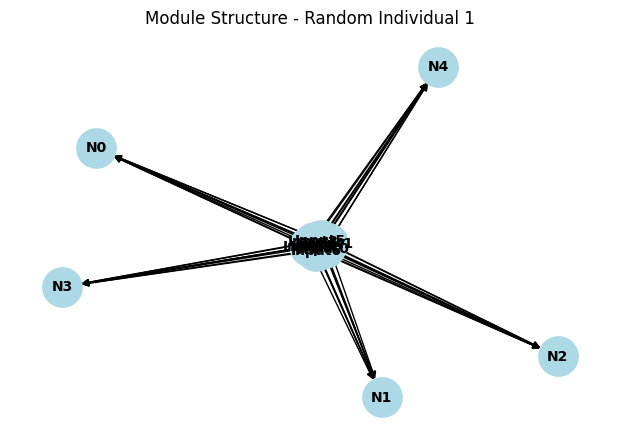

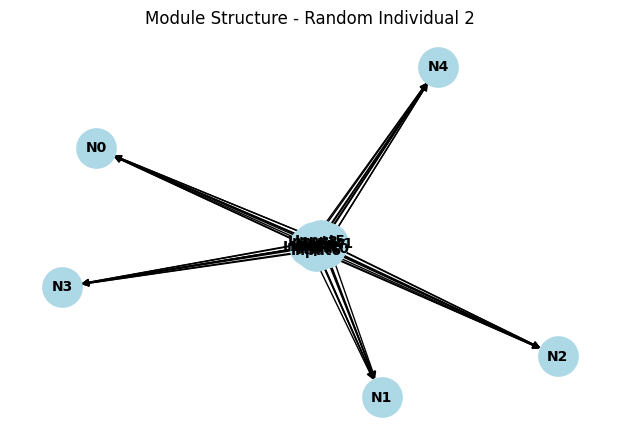

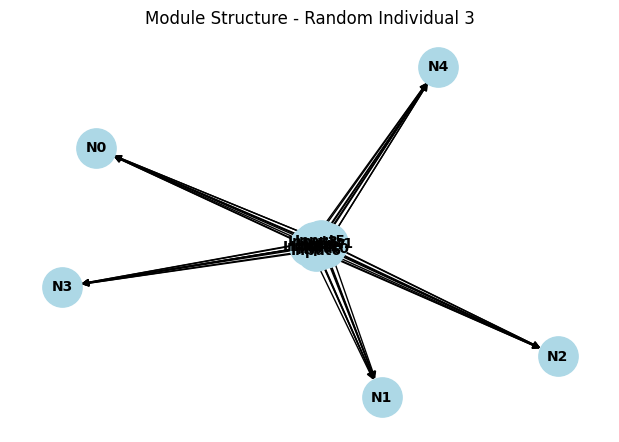

🎞️ Creating training progress GIF...
✅ GIF created at training_progress.gif


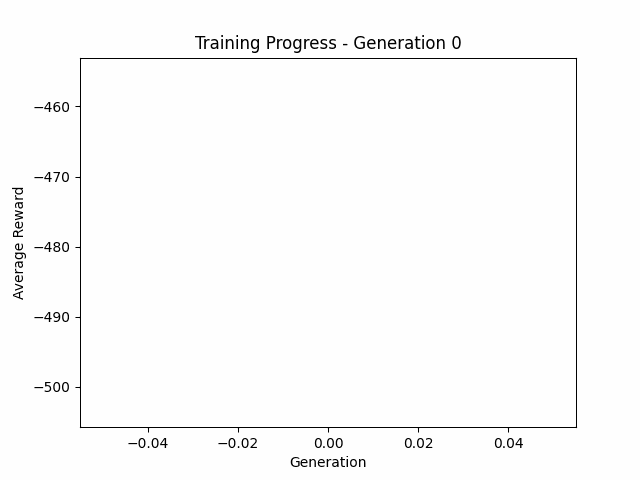

In [2]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install matplotlib networkx imageio

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from copy import deepcopy
import imageio.v2 as imageio
import networkx as nx
from IPython.display import display, Image

# ----------------------------- #
# 超参数配置
# ----------------------------- #
INPUT_SIZE = 8
OUTPUT_SIZE = 4
HIDDEN_SIZE = 40
MODULE_SIZE = 5
POP_SIZE = 60
GENERATIONS = 120
EPISODES_PER_NETWORK = 4
MUTATION_RATE = 0.25
ELITE_RATIO = 0.25
OUTPUT_MUTATION_STRENGTH = 0.03



# ----------------------------- #
# 激活函数
# ----------------------------- #
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# ----------------------------- #
# 基因组定义
# ----------------------------- #
class NeuronGenome:
    def __init__(self, input_size):
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()

    def mutate(self):
        if np.random.rand() < MUTATION_RATE:
            self.weights += np.random.randn(*self.weights.shape) * 0.1
            self.bias += np.random.randn() * 0.1

    def copy(self):
        copied = NeuronGenome(len(self.weights))
        copied.weights = np.copy(self.weights)
        copied.bias = self.bias
        return copied

    def __getstate__(self):
        return {'weights': self.weights, 'bias': self.bias}

    def __setstate__(self, state):
        self.weights = state['weights']
        self.bias = state['bias']

class HESPModule:
    def __init__(self, num_neurons, input_size):
        self.neurons = [NeuronGenome(input_size) for _ in range(num_neurons)]

    def forward(self, x):
        return [np.dot(n.weights, x) + n.bias for n in self.neurons]

    def copy(self):
        mod = HESPModule(0, 0)
        mod.neurons = [n.copy() for n in self.neurons]
        return mod

    def mutate(self):
        for neuron in self.neurons:
            neuron.mutate()

class HESPNetwork:
    def __init__(self, modules):
        self.modules = modules
        self.output_weights = np.random.randn(len(modules) * MODULE_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        h = relu(np.concatenate([m.forward(x) for m in self.modules]))
        return softmax(np.dot(h, self.output_weights))

# ----------------------------- #
# 评估函数
# ----------------------------- #
def evaluate(network, env_name="LunarLander-v3"):
    env = gym.make(env_name)
    total_reward = 0
    for _ in range(EPISODES_PER_NETWORK):
        obs, _ = env.reset()
        done = False
        while not done:
            action_probs = network.forward(obs)
            action = np.argmax(action_probs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
    env.close()
    return total_reward / EPISODES_PER_NETWORK

# ----------------------------- #
# H-ESP 主函数
# ----------------------------- #
def run_hesp():
    num_modules = HIDDEN_SIZE // MODULE_SIZE
    subpops = [[HESPModule(MODULE_SIZE, INPUT_SIZE) for _ in range(POP_SIZE)] for _ in range(num_modules)]
    output_weight_pool = [np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) for _ in range(POP_SIZE)]
    best_scores = []

    # 创建目录用于保存图像
    os.makedirs("charts", exist_ok=True)

    for gen in range(GENERATIONS):
        networks = []
        fitnesses = []

        for _ in range(POP_SIZE):
            indices = [random.randint(0, POP_SIZE-1) for _ in range(num_modules)]
            modules = [subpops[i][idx] for i, idx in enumerate(indices)]
            network = HESPNetwork(modules)
            network.output_weights = output_weight_pool[random.randint(0, POP_SIZE-1)]
            reward = evaluate(network)
            networks.append((network, indices))
            fitnesses.append(reward)

        usage = [[0]*POP_SIZE for _ in range(num_modules)]
        rewards = [[0.0]*POP_SIZE for _ in range(num_modules)]

        for idx, ((network, indices), reward) in enumerate(zip(networks, fitnesses)):
            for i, m_idx in enumerate(indices):
                usage[i][m_idx] += 1
                rewards[i][m_idx] += reward

        num_elites = int(POP_SIZE * ELITE_RATIO)
        for i in range(num_modules):
            avg_rewards = [rewards[i][j] / (usage[i][j] or 1) for j in range(POP_SIZE)]
            ranked = sorted(zip(avg_rewards, subpops[i]), key=lambda x: x[0], reverse=True)
            elites = [g.copy() for _, g in ranked[:num_elites]]
            next_pop = elites

            while len(next_pop) < POP_SIZE:
                parent = random.choice(elites)
                offspring = mutate_copy_module(parent)
                next_pop.append(offspring)

            subpops[i] = next_pop

        sorted_fitness = np.argsort(fitnesses)[::-1]
        elite_outputs = [output_weight_pool[i] for i in sorted_fitness[:num_elites]]

        next_outputs = []
        for w in elite_outputs:
            next_outputs.append(w.copy())

        for _ in range(POP_SIZE - num_elites):
            base = random.choice(elite_outputs)
            mutated = base + np.random.randn(*base.shape) * OUTPUT_MUTATION_STRENGTH
            next_outputs.append(mutated)

        output_weight_pool = next_outputs

        mean_score = np.mean(fitnesses)
        best_score = np.max(fitnesses)
        best_scores.append(mean_score)
        print(f"[H-ESP] Generation {gen}: avg reward = {mean_score:.2f}, best = {best_score:.2f}")

        # 保存每一代的图表
        if gen % (GENERATIONS // 10) == 0 or gen == GENERATIONS - 1:
            save_generation_chart(best_scores, gen)

    return subpops, output_weight_pool, best_scores

# ----------------------------- #
# 工具函数
# ----------------------------- #
def mutate_copy_neuron(neuron):
    new_neuron = neuron.copy()
    new_neuron.mutate()
    return new_neuron

def mutate_copy_module(module):
    new_module = module.copy()
    new_module.mutate()
    return new_module

def plot_module_structure(module, title="Module Structure"):
    G = nx.DiGraph()
    for i in range(INPUT_SIZE):
        G.add_node(f"Input{i}")
    neuron_nodes = [f"N{j}" for j in range(MODULE_SIZE)]
    for neuron in neuron_nodes:
        G.add_node(neuron)
    for i in range(INPUT_SIZE):
        for j in range(MODULE_SIZE):
            G.add_edge(f"Input{i}", f"N{j}")

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title(title)
    plt.show()

def save_generation_chart(best_scores, gen):
    plt.plot(best_scores, label='Best Score')
    plt.xlabel("Generation")
    plt.ylabel("Average Reward")
    plt.title(f"Training Progress - Generation {gen}")
    filename = f"charts/gen_{gen}.png"
    plt.savefig(filename)
    plt.close()
    return filename

def create_training_gif(generations):
    images = []
    for gen in range(0, generations, max(1, generations // 10)):
        filename = f"charts/gen_{gen}.png"
        try:
            images.append(imageio.imread(filename))
        except FileNotFoundError:
            print(f"⚠️ File not found: {filename}")
    gif_filename = 'training_progress.gif'
    imageio.mimsave(gif_filename, images, duration=0.5)
    print("✅ GIF created at training_progress.gif")

def save_model(subpops, output_weights, filename="hesp_model.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump((subpops, output_weights), f)

# ----------------------------- #
# 主程序入口
# ----------------------------- #
if __name__ == '__main__':
    subpops, output_weights, hesp_scores = run_hesp()
    save_model(subpops, output_weights)

    # 随机选取三个个体绘制模块结构图（避免越界）
    print("📊 Drawing module structures...")
    plot_module_structure(random.choice(subpops[0]), "Module Structure - Random Individual 1")
    plot_module_structure(random.choice(subpops[0]), "Module Structure - Random Individual 2")
    plot_module_structure(random.choice(subpops[0]), "Module Structure - Random Individual 3")

    # 创建 GIF
    print("🎞️ Creating training progress GIF...")
    create_training_gif(GENERATIONS)

    # 显示 GIF
    display(Image(data=open('training_progress.gif', 'rb').read()))